In [1]:
##Author Tushar Kant Roy
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Concatenate, Average, Maximum, CuDNNLSTM, CuDNNGRU, Bidirectional, TimeDistributed
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine.input_layer import Input
from keras.models import load_model

import matplotlib.pyplot as plt


import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(7723)
tf.set_random_seed(1090)

In [3]:
###Read the data
train_df = pd.read_csv('../data/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

In [4]:

#####Length of training sample
print(train_df.acoustic_data.values.shape)

###Assign train smaples and label
X_train = train_df.acoustic_data.values
print(X_train.shape)
y_train = train_df.time_to_failure.values


### Find different segments in the training data 
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)
train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)


(629145480,)
(629145480,)
[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


In [24]:
print(y_train[5656573])

0.0007954798


[5656573,
 44429304,
 54591478,
 34095097,
 48869367,
 31010810,
 27176955,
 62009332,
 30437370,
 37101561,
 43991032,
 42442743,
 33988602,
 32976890,
 56791029,
 36417529]

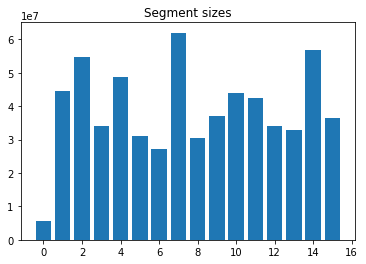

In [17]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])
[ s[1] - s[0] for s in train_segments]

In [56]:
train_segments[10]

(375377847, 419368879)

array([ 5656573, 27176955, 30437370, 31010810, 32976890, 33988602,
       34095097, 36417529, 37101561, 42442743, 43991032, 44429304,
       48869367, 54591478, 56791029, 62009332])

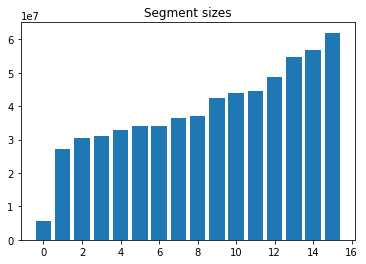

In [35]:
a = [s[1] - s[0] for s in train_segments]

a = np.sort(a)
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), a)
a
#np.sum(a)

In [11]:
a = X_train[0:5656573]
b = y_train[0:5656573]
print("mean",a.mean())
print("max",a.max())
print("min",a.min())
print("std",a.std())
print("no. of times signal above 80:",np.where(a > 80)[0].size)
print("no. of times signal below 80:",np.where(a < -80)[0].size)
print("time to failure at start:",b[0])

mean 4.545052631690601
max 127
min -128
std 7.417107637473003
no. of times signal above 80: 3800
no. of times signal below 80: 3353
time to failure at start: 1.4691


In [ ]:
for i in range(len(train_segments)):
    print("segment",i+1)
    print("time to failure from start",y_train[train_segments[i][0]])
    a = X_train[train_segments[i][0]:train_segments[i][1]+1]
    b = y_train[train_segments[i][0]+1:train_segments[i][1]+1]
    print("mean",a.mean())
    print("max",a.max())
    print("min",a.min())
    print("std",a.std())
    print("no. of times signal above 80:",np.where(a > 80)[0].size)
    print("no. of times signal below 80:",np.where(a < -80)[0].size)
    print("time to failure at start:",b[0])

In [15]:
print("time to failure from start",y_train[218652630])
a = X_train[240173011:245829584]
b = y_train[240173011:245829584]
print("mean",a.mean())
print("max",a.max())
print("min",a.min())
print("std",a.std())
print("no. of times signal above 80:",np.where(a > 80)[0].size)
print("no. of times signal below 80:",np.where(a < -80)[0].size)
print("time to failure at start:",b[0])

time to failure from start 7.059
mean 4.185136831081293
max 127
min -128
std 7.32726447877034
no. of times signal above 80: 3665
no. of times signal below 80: 3139
time to failure at start: 1.4688


In [13]:
print("time to failure from start",y_train[245829585])
a = X_train[302182343:307838916]
b = y_train[302182343:307838916]
print("mean",a.mean())
print("max",a.max())
print("min",a.min())
print("std",a.std())
print("no. of times signal above 80:",np.where(a > 80)[0].size)
print("no. of times signal below 80:",np.where(a < -80)[0].size)
print("time to failure at start:",b[0])

time to failure from start 16.1074
mean 4.338885399339848
max 127
min -128
std 8.304367757281412
no. of times signal above 80: 4744
no. of times signal below 80: 3882
time to failure at start: 1.469


In [89]:
meanstd =[]
for i in range(len(train_segments)):
    print("segment",i+1)
    a = X_train[train_segments[i][0]:train_segments[i][1]+1]
    b = y_train[train_segments[i][0]+1:train_segments[i][1]+1]
    print("mean",a.mean())
    print("max",a.max())
    print("min",a.min())
    print("std",a.std())
    meanstd.append(a.std())
    print("no. of times signal above 80:",np.where(a > 80)[0].size)
    print("no. of times signal below 80:",np.where(a < -80)[0].size)
    print("time to failure at start:",b[0])
meanstd =np.asarray(meanstd)
meanstd.mean()

segment 1
mean 4.545052535333225
max 127
min -128
std 7.417106985395062
no. of times signal above 80: 3800
no. of times signal below 80: 3353
time to failure at start: 1.4691
segment 2
mean 4.501382297112232
max 127
min -128
std 6.042307582690468
no. of times signal above 80: 13588
no. of times signal below 80: 11008
time to failure at start: 11.5408
segment 3
mean 4.790407143942739
max 127
min -128
std 6.3853029922143545
no. of times signal above 80: 20354
no. of times signal below 80: 15436
time to failure at start: 14.1806
segment 4
mean 4.691033004216618
max 127
min -128
std 6.183073120841292
no. of times signal above 80: 12029
no. of times signal below 80: 9582
time to failure at start: 8.8567
segment 5
mean 4.622582330100934
max 127
min -128
std 6.625357433239476
no. of times signal above 80: 21938
no. of times signal below 80: 18143
time to failure at start: 12.694
segment 6
mean 4.485746728777909
max 127
min -128
std 5.853671394786928
no. of times signal above 80: 9562
no. of t

6.212853736230416

100%|██████████| 2624/2624 [00:47<00:00, 55.32it/s]


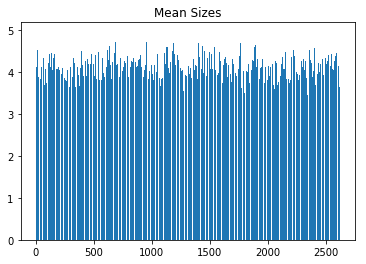

In [21]:
from tqdm import tqdm
submission = pd.read_csv('../data/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})
mean = []
maxV = []
minV = []
stdV = []
pThresholdCount = []
nThresholdCount = []
pThreshold = 80
nThreshold = -80
x = []
# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../data/test/' + seg_id + '.csv')
    x.append(seg['acoustic_data'].values)
    #print("Segment"+str(i+1)+":")
    mean.append(x[i].mean())
    maxV.append(x[i].max())
    minV.append(x[i].max())
    stdV.append(x[i].std())
    pThresholdCount.append(np.where(x[i] > pThreshold)[0].size)
    nThresholdCount.append(np.where(x[i] < nThreshold)[0].size)
    



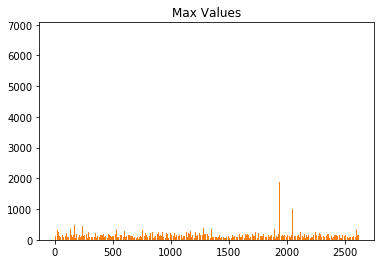

In [73]:
plt.title('Mean Sizes')
_ = plt.bar(np.arange(len(mean)), [ s for s in mean])

plt.title('Max Values')
_ = plt.bar(np.arange(len(maxV)), [ s for s in maxV])



In [74]:
maxV = np.asarray(maxV)
print("max above 1000:")
print(np.where(maxV > 500))
t = np.where(maxV > 500)[0]
print(t.shape)
maxV[145]
maxV.max(axis=0)

max above 1000:
(array([   5,  145,  257,  375,  441,  469,  589,  622,  745,  771,  776,
        838,  850,  912, 1004, 1079, 1117, 1202, 1220, 1263, 1288, 1349,
       1380, 1408, 1433, 1614, 1693, 1709, 1795, 1828, 1939, 1970, 2010,
       2013, 2041, 2051, 2281, 2323, 2329, 2501, 2604, 2607]),)
(42,)


6741

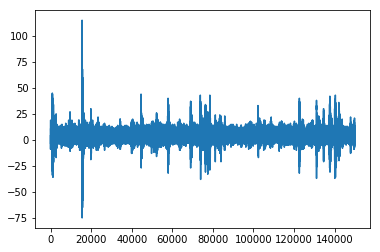

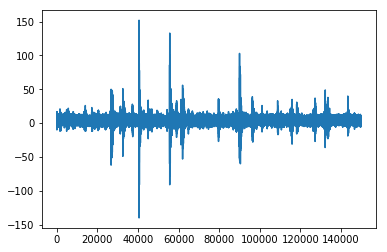

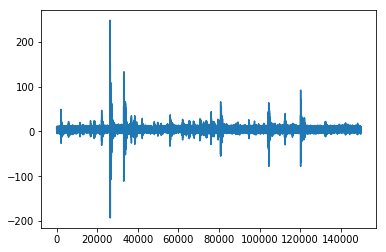

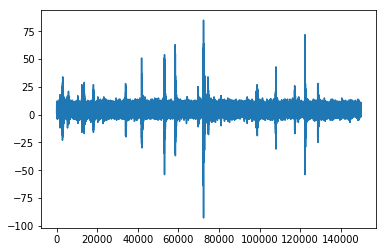

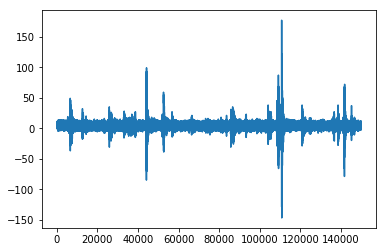

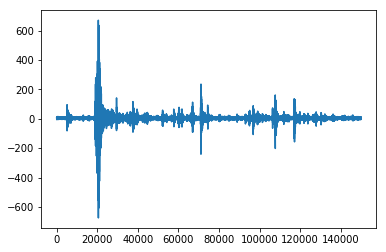

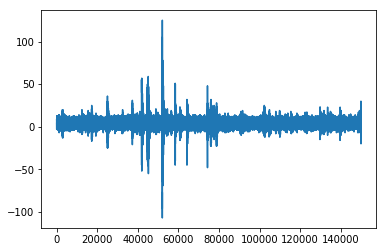

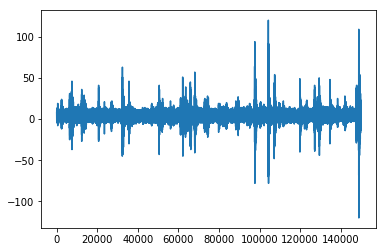

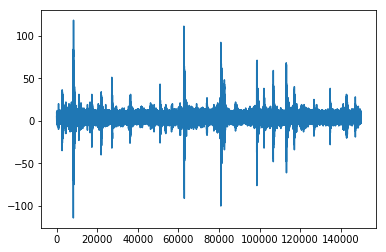

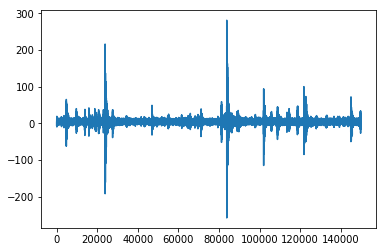

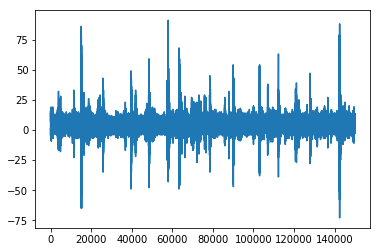

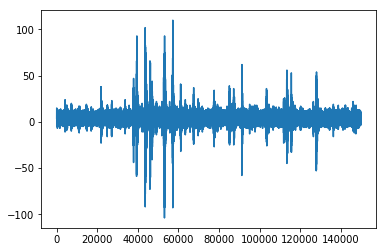

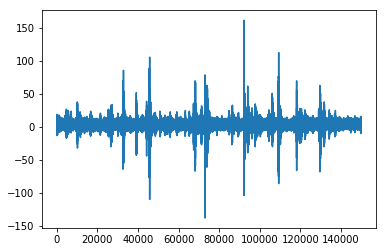

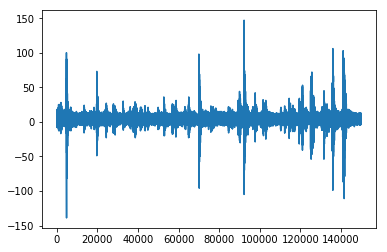

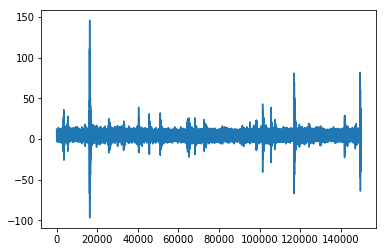

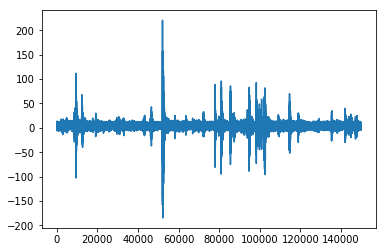

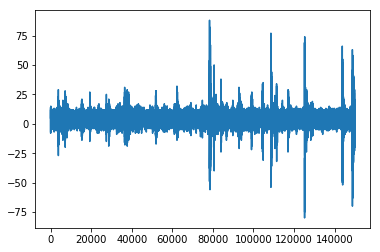

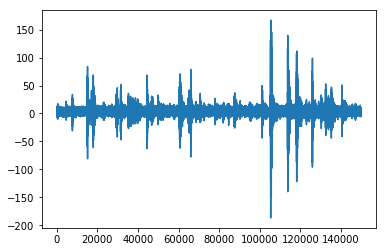

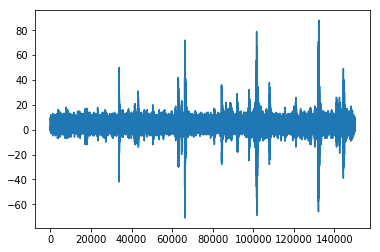

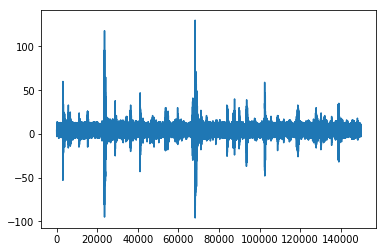

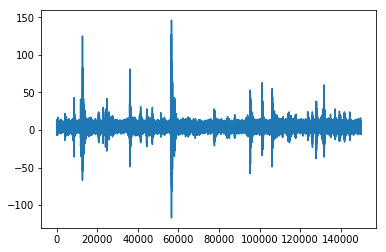

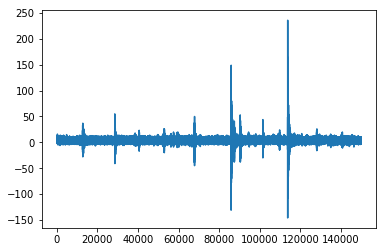

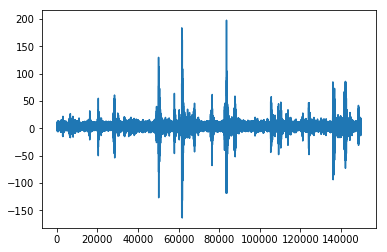

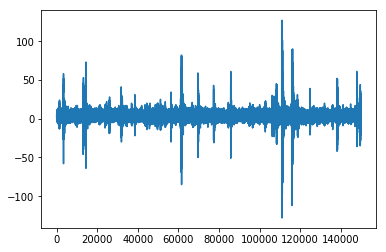

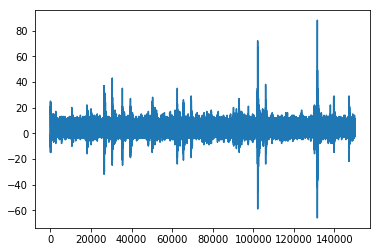

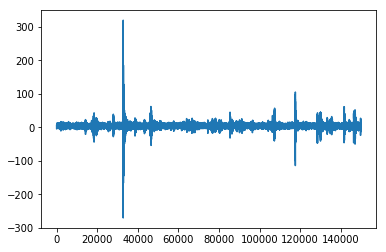

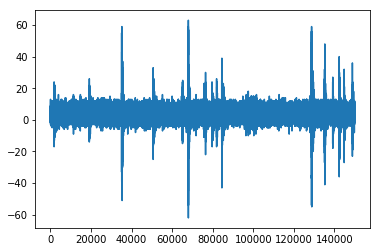

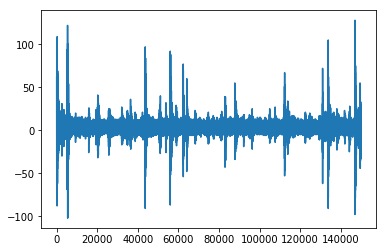

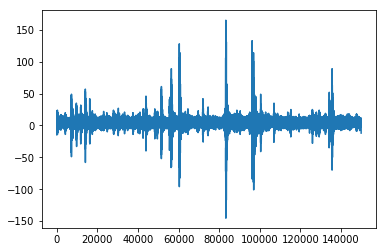

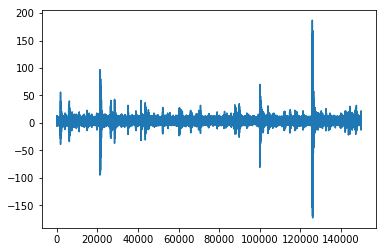

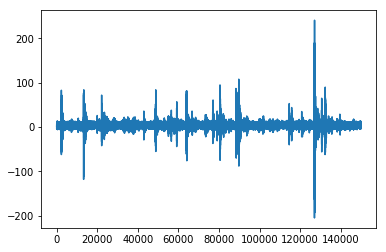

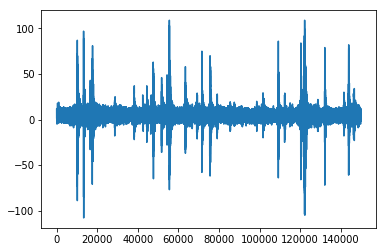

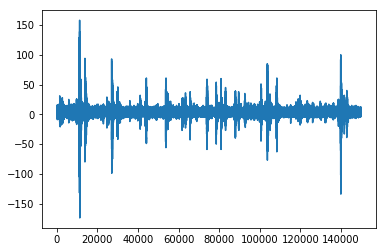

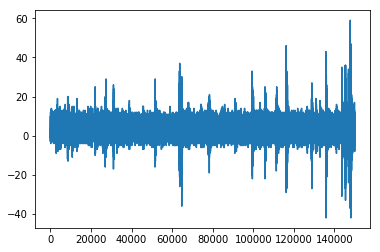

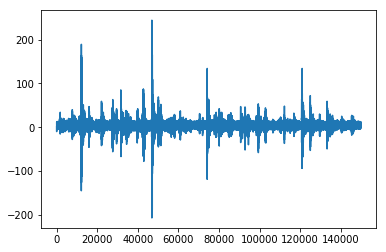

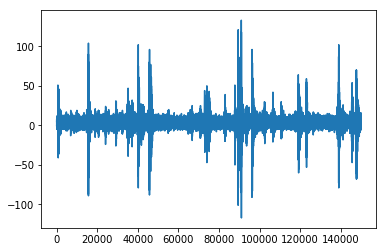

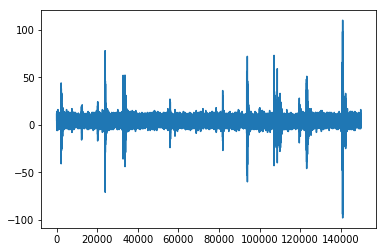

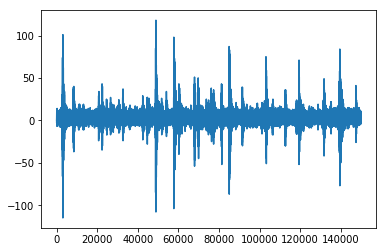

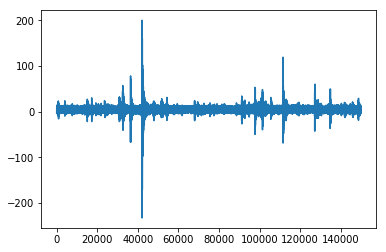

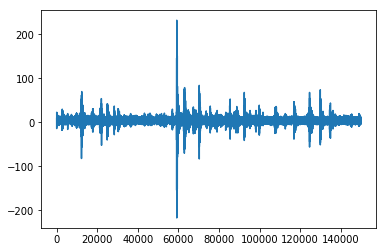

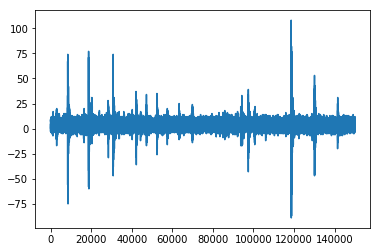

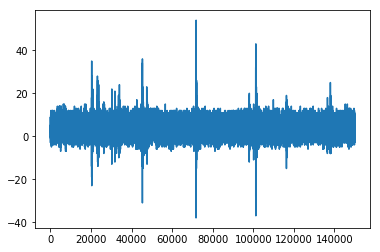

In [75]:
stdbig = []
for i in range(len(t)):
    plt.plot([i for i in range(len(x[i][np.where(np.abs(x[i]) < 2000)[0]]))],
         x[i][np.where(np.abs(x[i]) < 2000)[0]])
    plt.show()
    stdbig.append(x[i][np.where(np.abs(x[i]) < 2000)[0]].std())


In [88]:
stdbig = np.asarray(stdbig)
stdbig[np.where(stdbig < 15)].mean()

6.229609246071844

In [44]:
np.where(x[1263] > -0.0009)

(array([     0,      1,      2, ..., 149997, 149998, 149999]),)

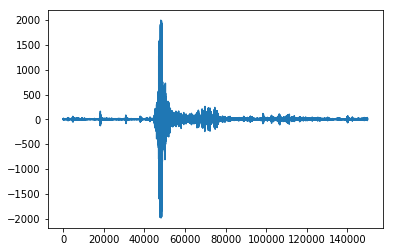

In [66]:
plt.plot([i for i in range(len(x[1263][np.where(np.abs(x[1263]) < 2000)[0]]))],
         x[1263][np.where(np.abs(x[1263]) < 2000)[0]])

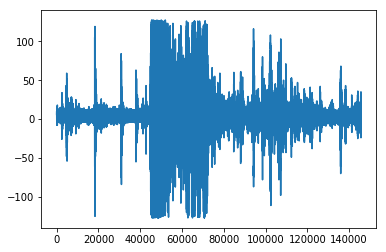

In [50]:
plt.plot([i for i in range(len(x[1263][np.where(np.abs(x[1263]) < 128)[0]]))],
         x[1263][np.where(np.abs(x[1263]) < 128)[0]])

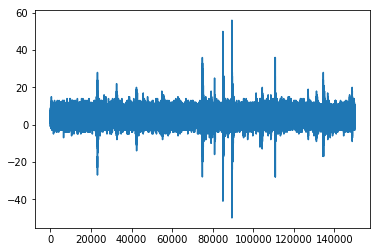

4.327073333333334


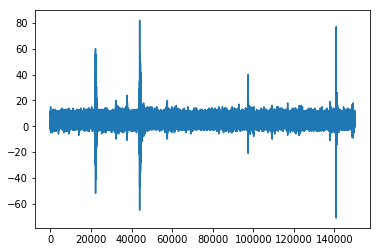

4.783453333333333


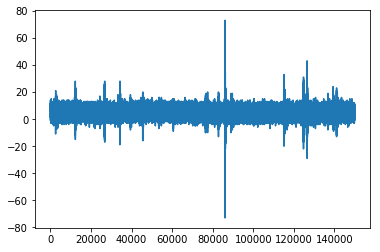

4.960906666666666


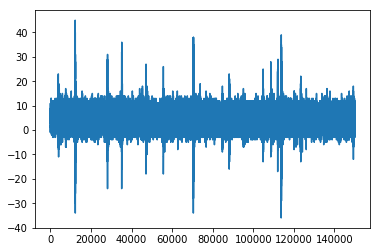

4.71866


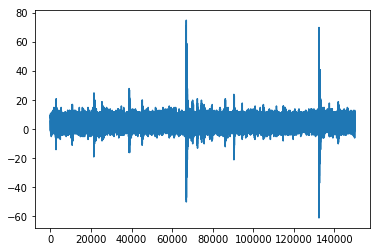

4.510153333333333


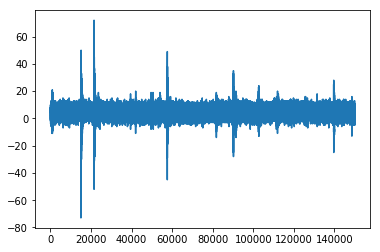

4.50034


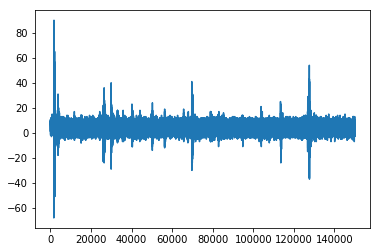

3.9623933333333334


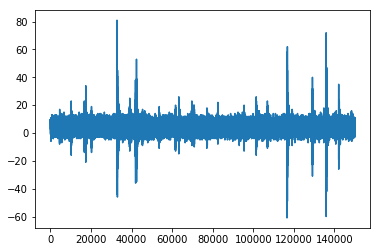

4.305166666666667


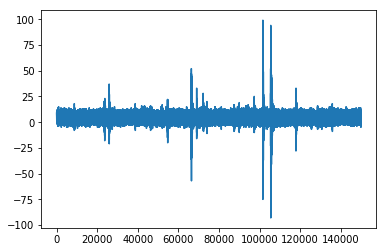

4.498273333333334


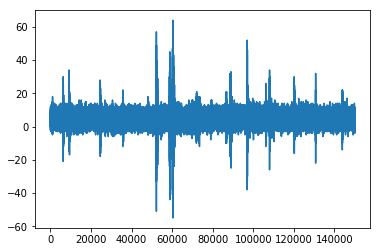

4.716393333333333


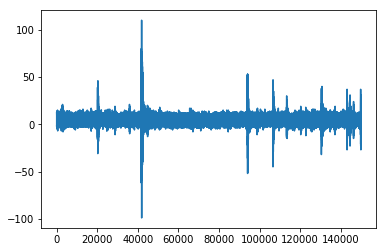

4.67208


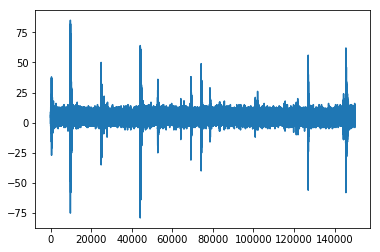

4.89504


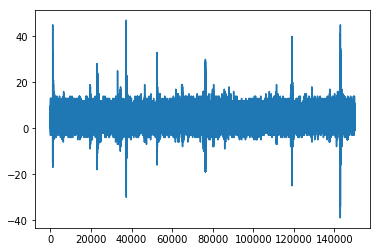

4.850673333333333


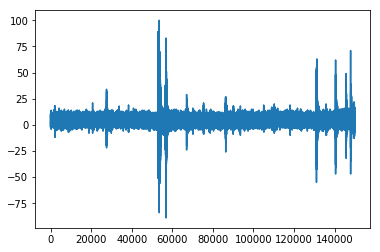

4.4987


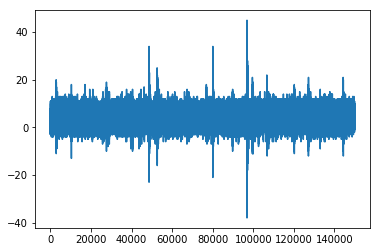

4.228886666666667


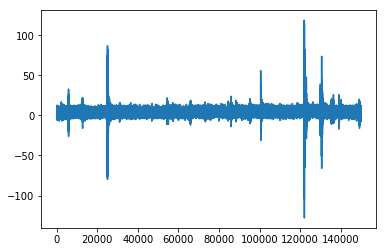

4.520693333333333


In [65]:
for i in range(len(train_segments)):
    plt.plot([i for i in range(len(X_train[train_segments[i][1] - 150000:train_segments[i][1]]))]
             ,X_train[train_segments[i][1] - 150000:train_segments[i][1]])
    plt.show()
    print(X_train[train_segments[i][1] - 150000:train_segments[i][1]].mean())

In [61]:
a = X_train[376706617:376856617]
a.std()

3.261614012560857

In [62]:
e = X_train[419218879:419368879]
e.std()

4.169086447524604

In [55]:
d = x[1263][np.where(np.abs(x[1263]) < 128)[0]]
d.std()

21.68730288397943

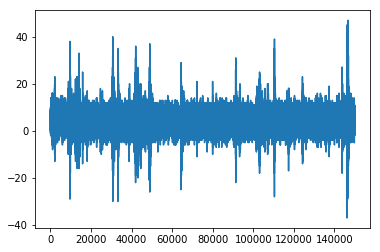

In [7]:
plt.plot([i for i in range(len(x[644]))],x[644])

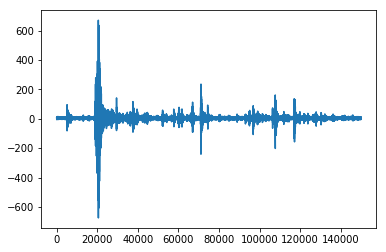

In [9]:
plt.plot([i for i in range(len(x[5]))],x[5])

In [ ]:
%matplotlib inline



matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
#data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
 
data = pd.DataFrame(data=X_train[0:5656573])

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color='C3')
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Amp')
ax.set_ylabel('Frequency')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


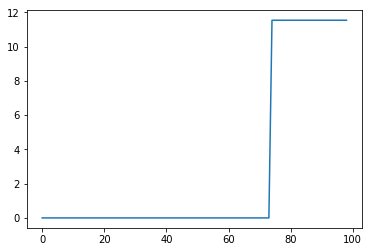

In [8]:
plt.plot([i for i in range(len(y_train[5656500:5656599]))], y_train[5656500:5656599])

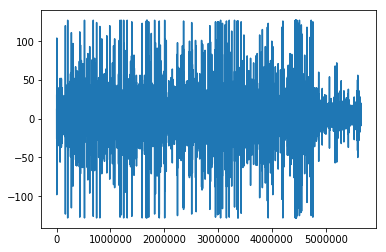

In [9]:
plt.plot([i for i in range(len(X_train[0:5656573]))],X_train[0:5656573])

/Users/tushar/Library/Python/3.7/lib/python/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/tushar/Library/Python/3.7/lib/python/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/tushar/Library/Python/3.7/lib/python/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

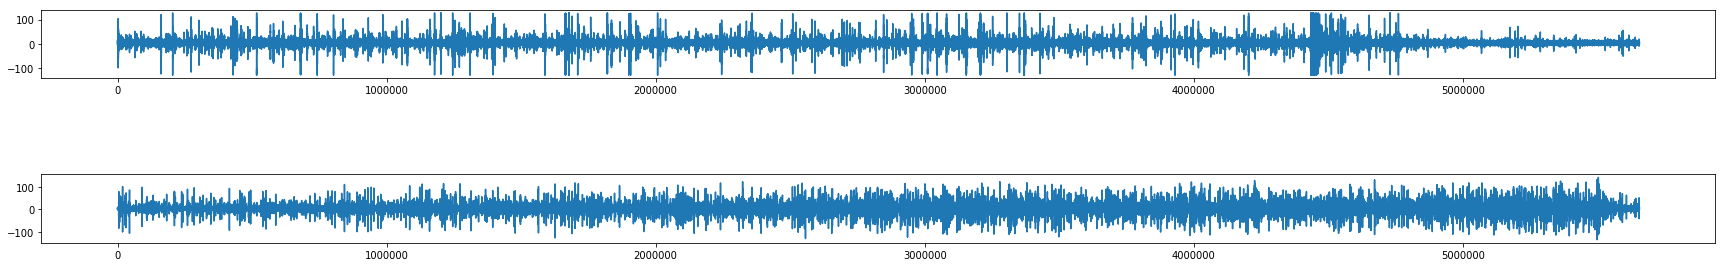

In [11]:
from scipy import signal
f = signal.resample(X_train[5656573:50085877],5656574)

plt.figure(figsize=(30,30))
plt.subplot2grid((20,1),(0,0),colspan=2)
plt.plot([i for i in range(len(X_train[0:5656573]))],X_train[0:5656573])
plt.subplot2grid((20,1),(2,0),colspan=2)
plt.plot([i for i in range(len(f))],f)

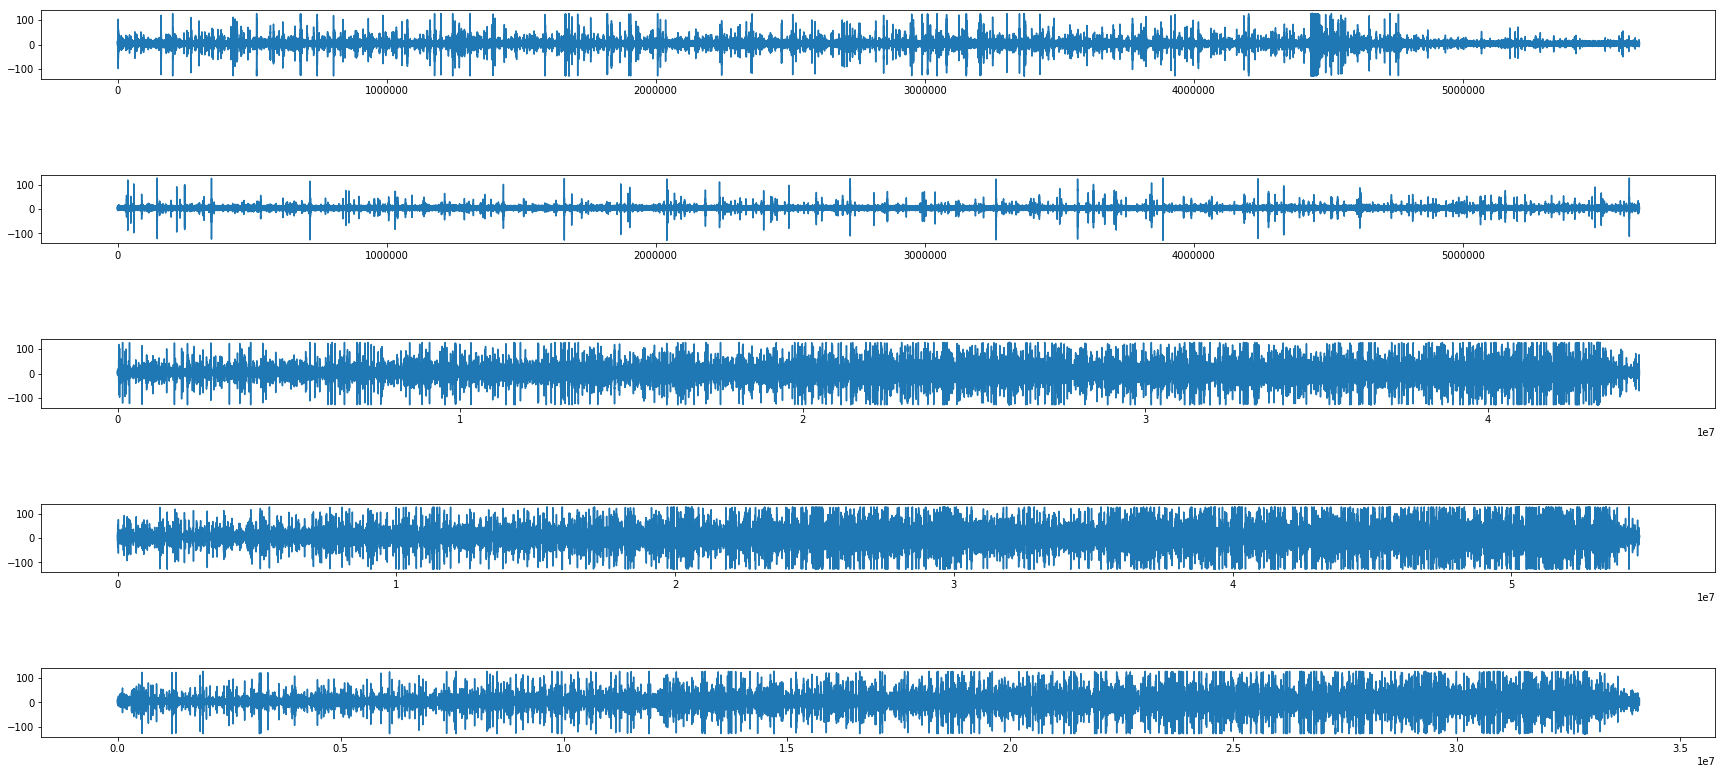

In [47]:
from matplotlib import gridspec
plt.figure(figsize=(30,30))
plt.subplot2grid((20,1),(0,0),colspan=2)
plt.plot([i for i in range(len(X_train[0:5656573]))],X_train[0:5656573])
plt.subplot2grid((20,1),(2,0),colspan=2)
plt.plot([i for i in range(len(X_train[5656573:11313146]))],X_train[5656573:11313146])
plt.subplot2grid((20,1),(4,0),colspan=2)
plt.plot([i for i in range(len(X_train[5656573:50085877]))],X_train[5656573:50085877])
plt.subplot2grid((20,1),(6,0),colspan=2)
plt.plot([i for i in range(len(X_train[50085877:104677355]))],X_train[50085877:104677355])
plt.subplot2grid((20,1),(8,0),colspan=2)
plt.plot([i for i in range(len(X_train[104677355:138772452]))],X_train[104677355: 138772452])
plt.show()

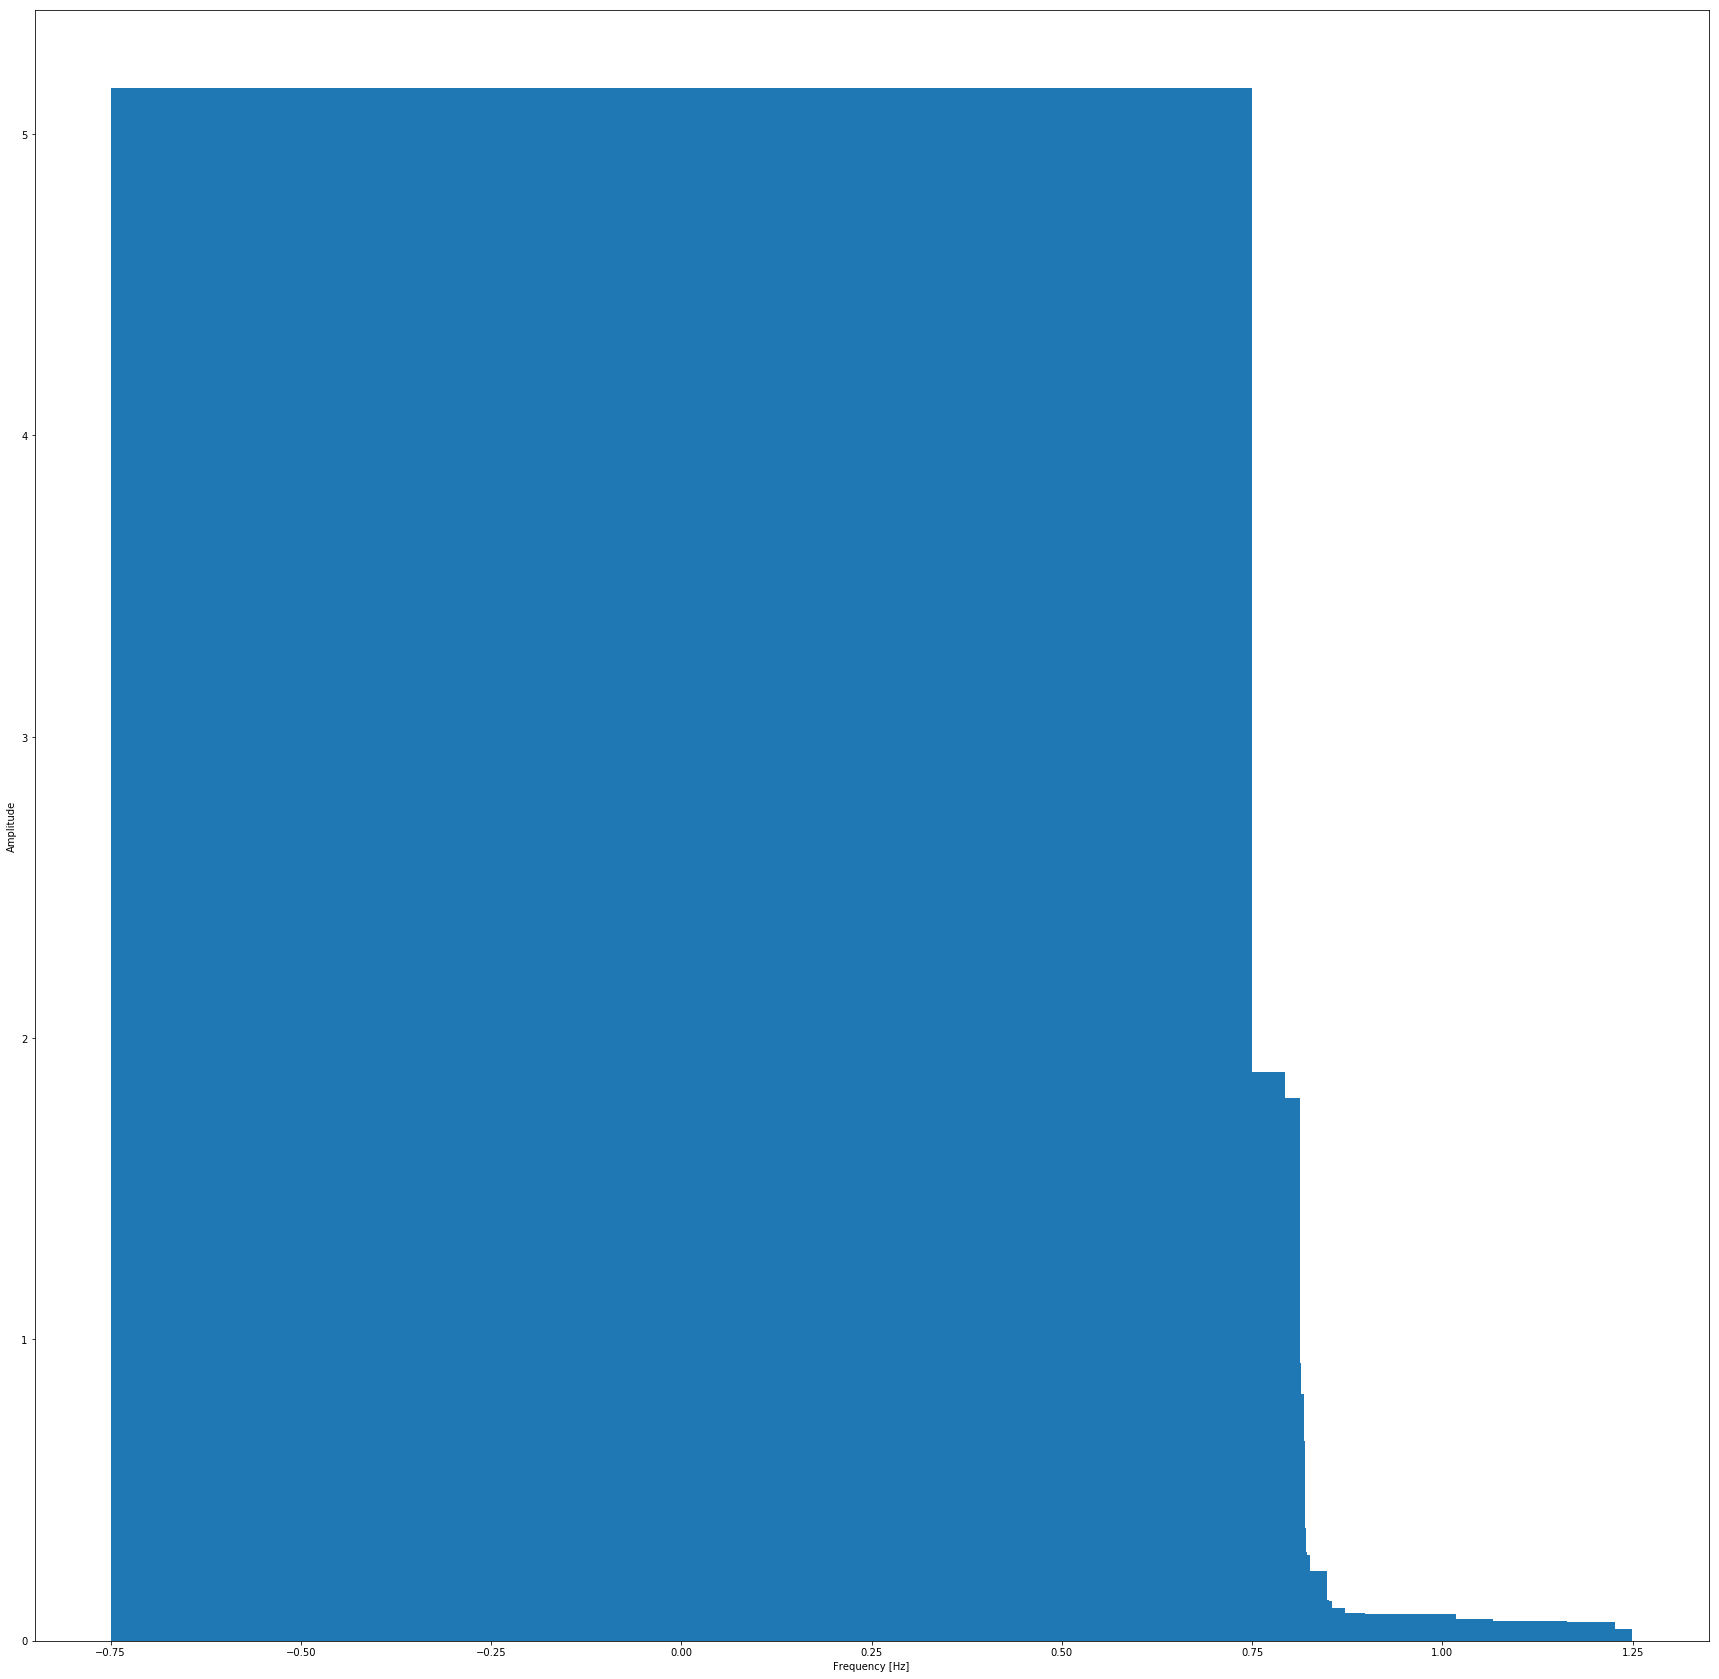

In [5]:
fft = np.fft.fft(X_train[0:5656])
number_sample = 5656 - 0
t = np.linspace(0, 5656, number_sample)  # sampling interval
T = t[1] - t[0]
N = X_train[0:5656].size
f = np.linspace(0, 1 / T, N)

plt.figure(figsize=(30,30))
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.show()

In [ ]:
fft = np.fft.fft(X_train[0:5656573])
number_sample = 5656573 - 0
t = np.linspace(0, 5656573, number_sample)  # sampling interval
T = t[1] - t[0]
N = X_train[0:5656573].size
f = np.linspace(0, 1 / T, N)

plt.figure(figsize=(30,30))
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.show()

In [ ]:
fft = np.fft.fft(X_train[5656573:50085877])
number_sample = 50085877 - 5656573
t = np.linspace(5656573, 50085877, number_sample)  # sampling interval
T = t[1] - t[0]
N = X_train[0:5656573].size
f = np.linspace(0, 1 / T, N)

plt.figure(figsize=(30,30))
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.show()

/Users/tushar/Library/Python/3.7/lib/python/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


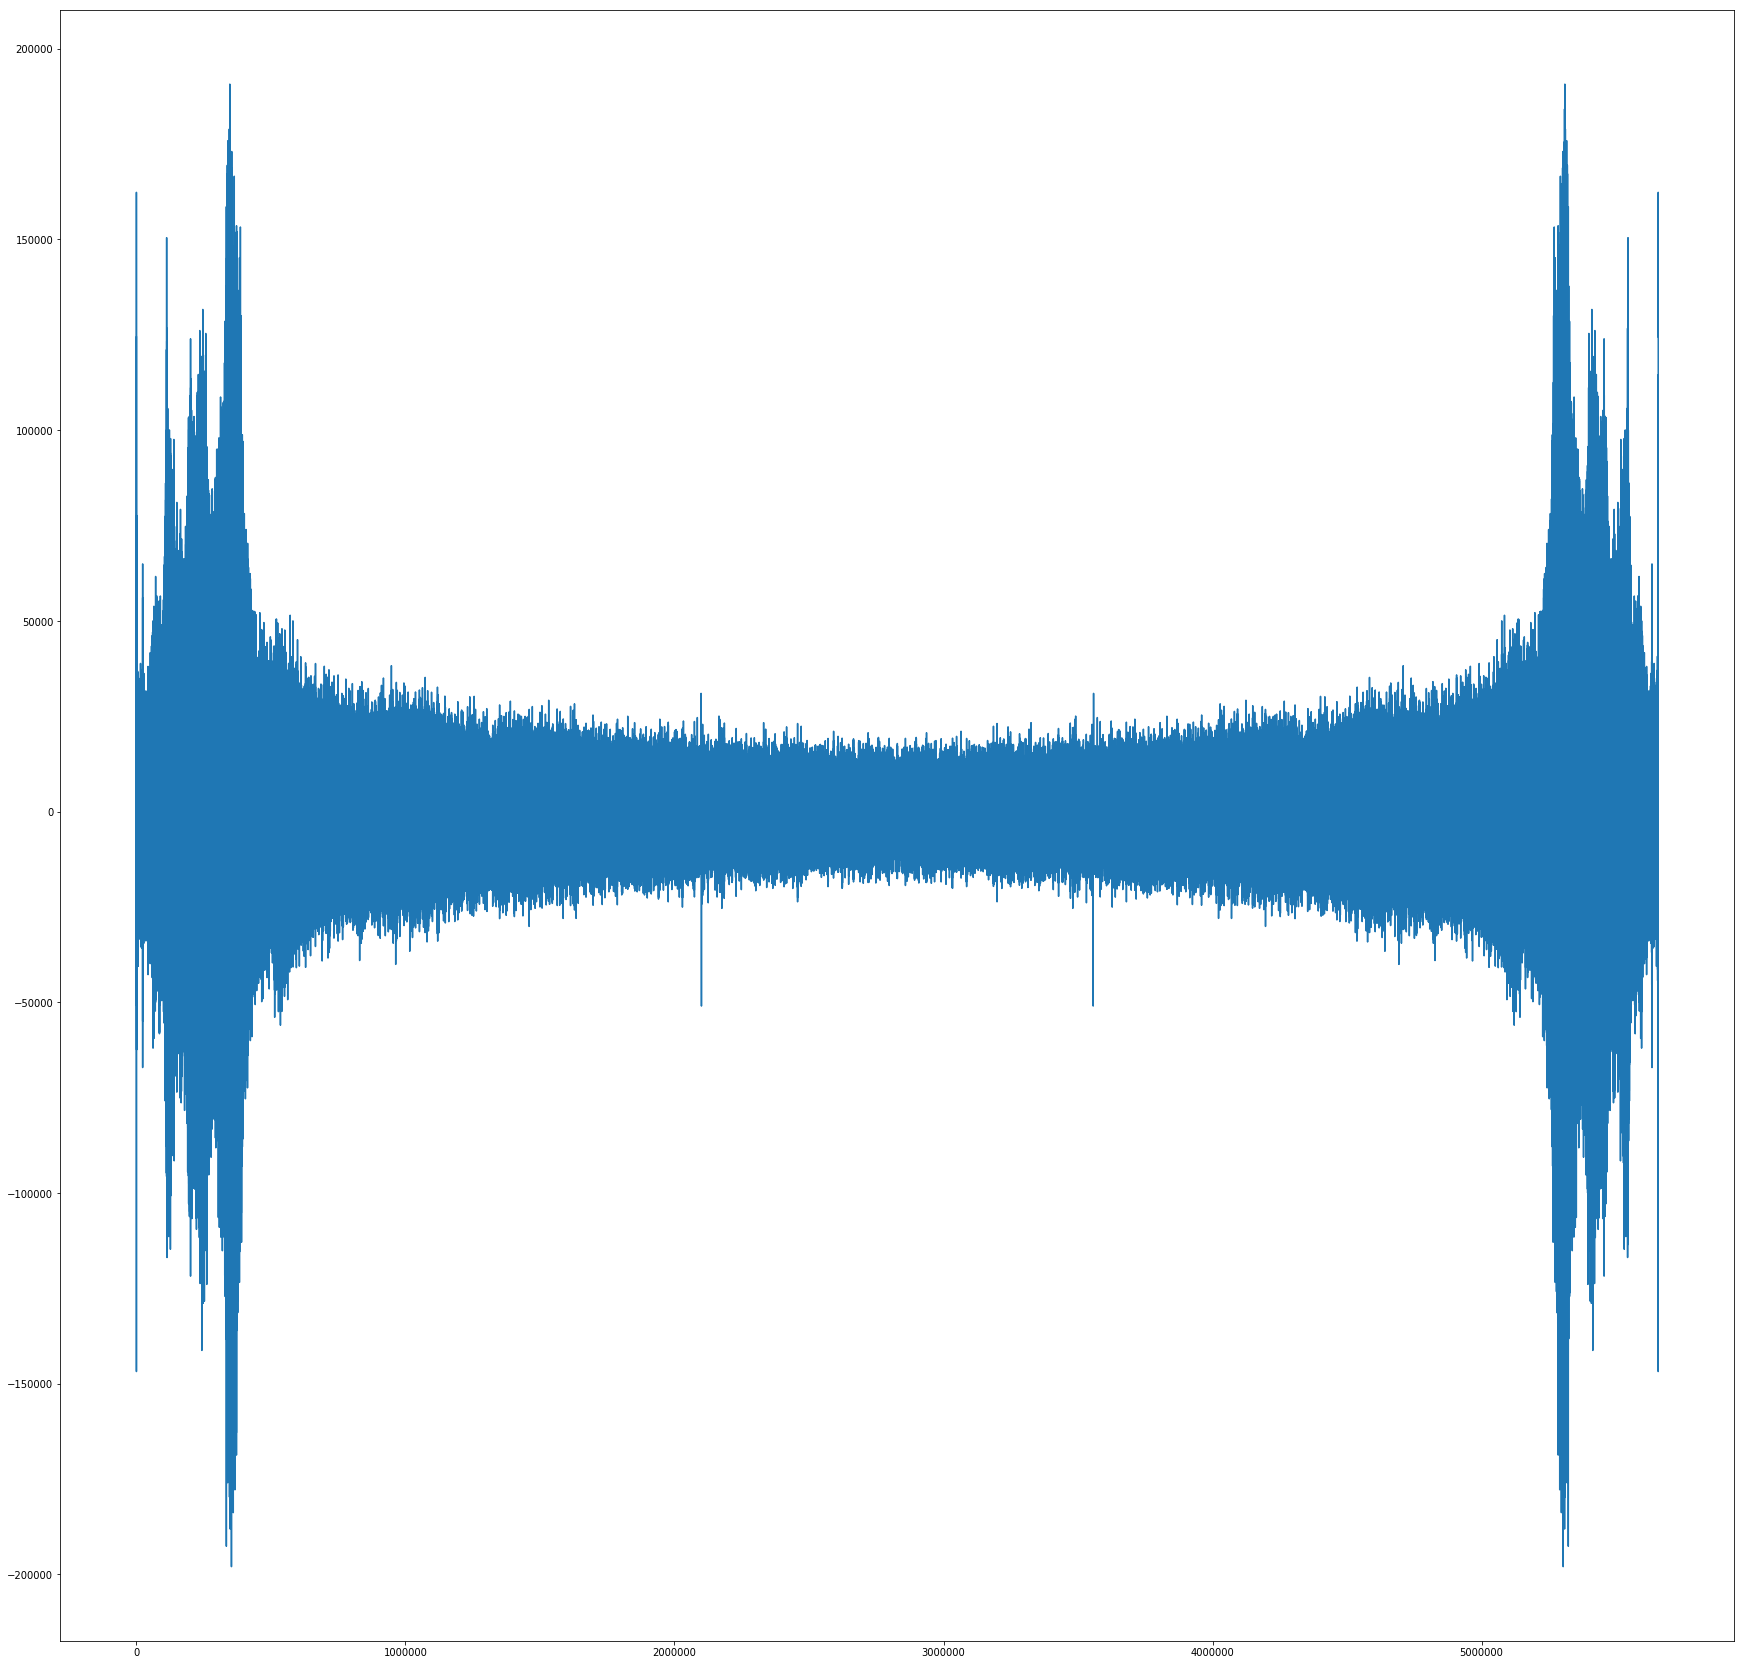

In [50]:
from scipy.fftpack import fft, ifft
S1_fft = fft(X_train[0:5656573])
S1_fft = S1_fft[1:]
plt.figure(figsize=(30,30))
plt.plot([i for i in range(len(S1_fft))],S1_fft)
plt.show()

/Users/tushar/Library/Python/3.7/lib/python/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


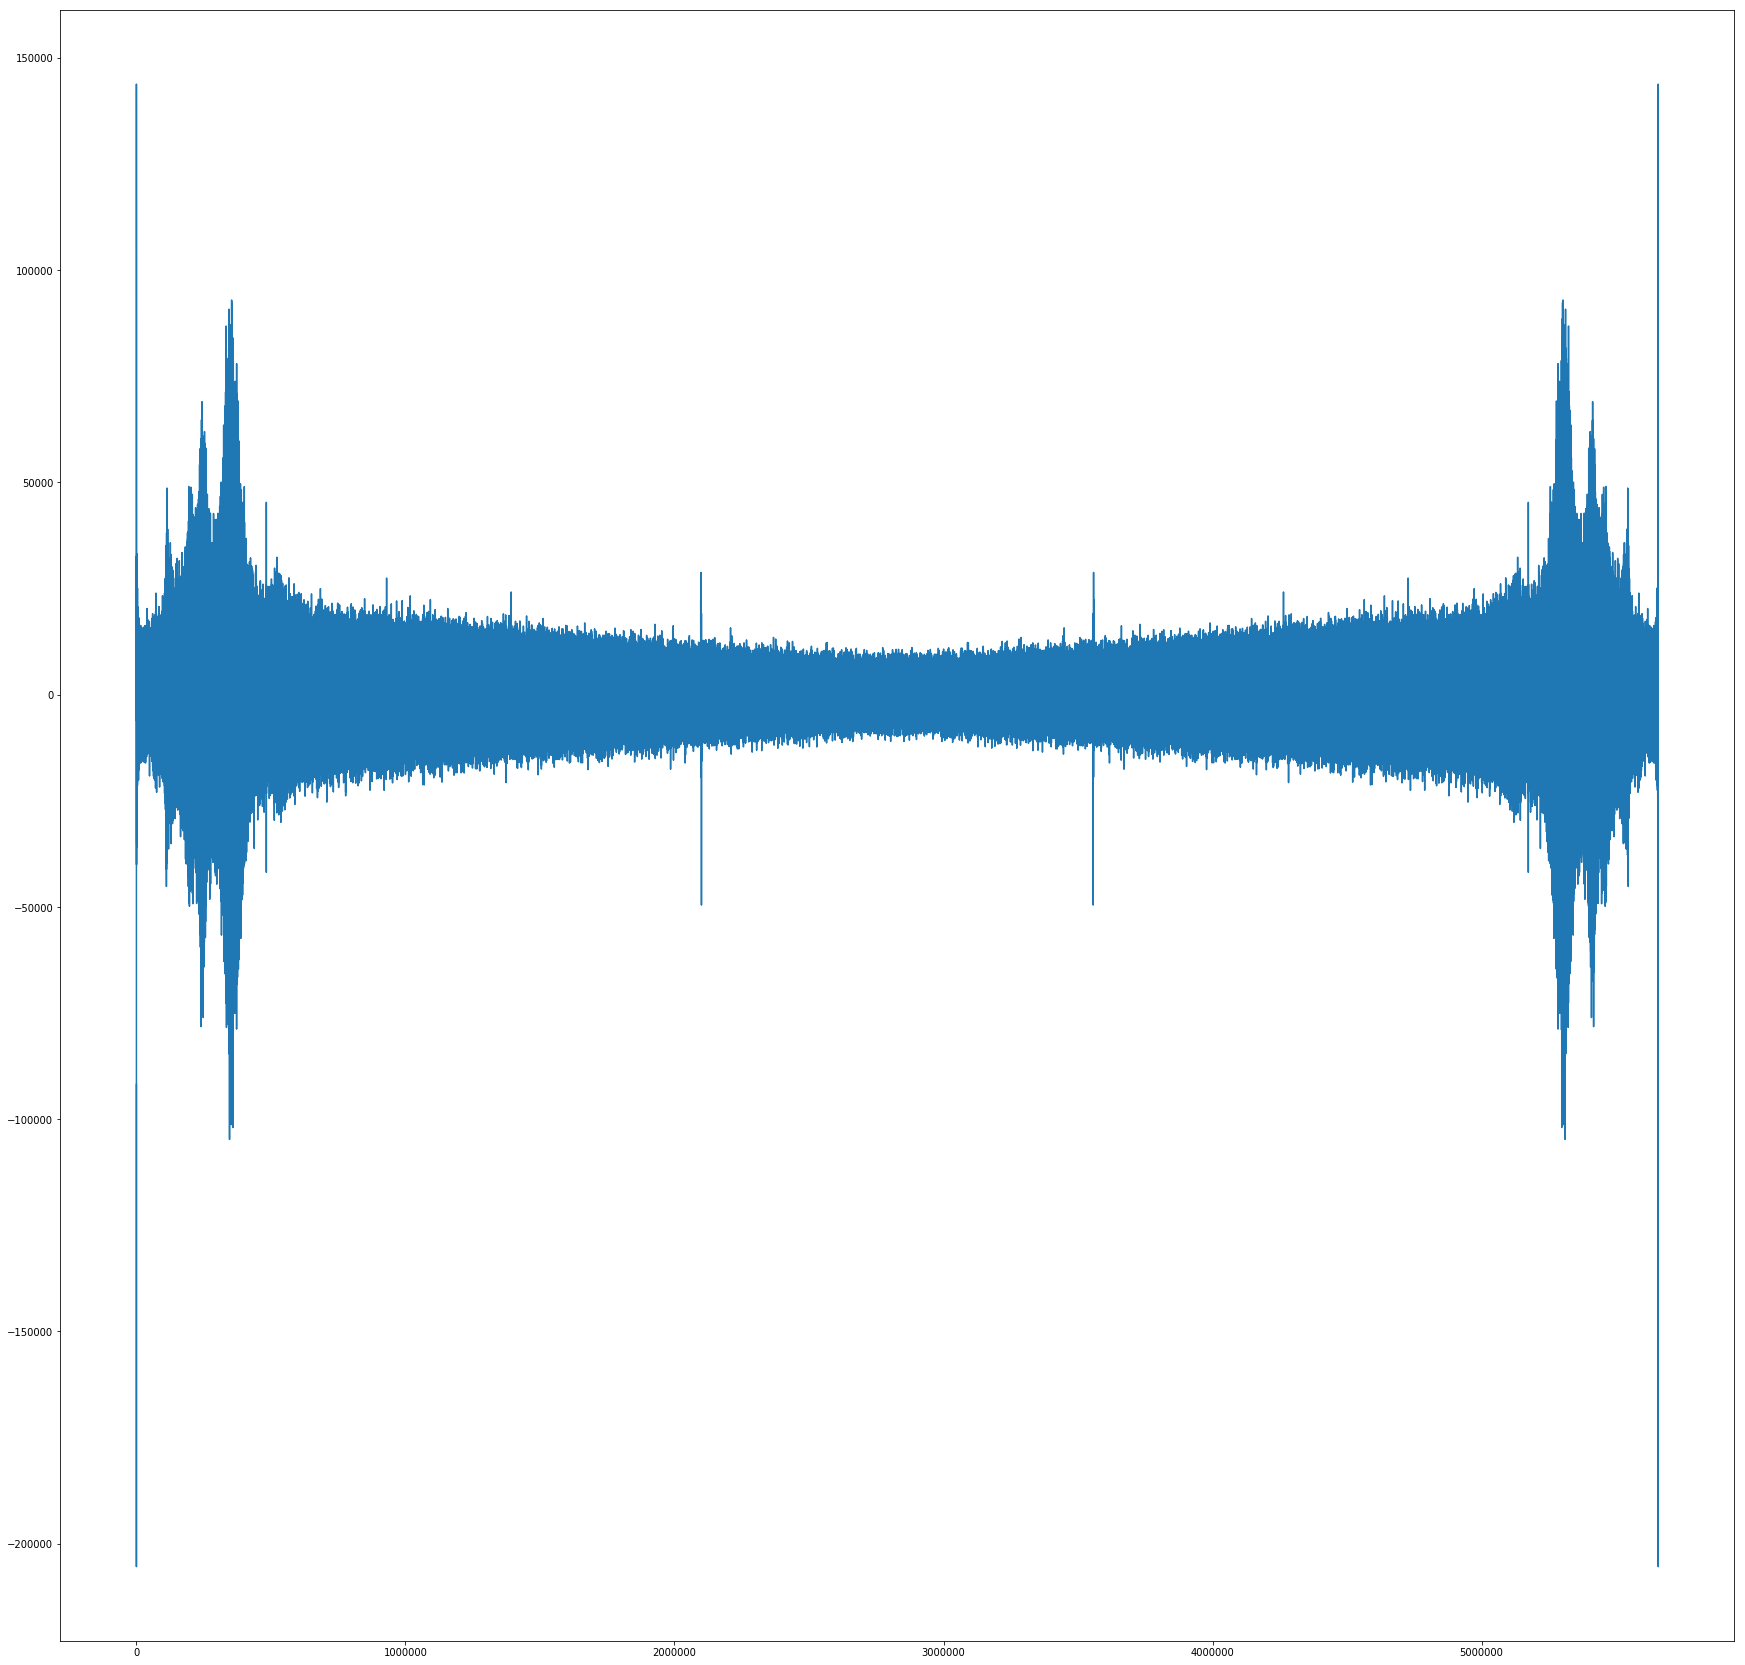

In [51]:
S2_fft = fft(X_train[5656573:11313146])
S2_fft = S2_fft[1:]
plt.figure(figsize=(30,30))
plt.plot([i for i in range(len(S2_fft))],S2_fft)
plt.show()

In [ ]:
S3_fft = fft(X_train[5656573:50085877])
S3_fft = np.where(S3_fft < 600000)
plt.figure(figsize=(30,30))
plt.plot([i for i in range(len(S3_fft))],S3_fft)
plt.show()